In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from torch.utils.data import WeightedRandomSampler
import numpy as np
import matplotlib.pyplot as plt

# Local imports
from lattice_utils import (
    MultiFileDataset,
    BinFileDataset,
    corr_2d,
    deformed_corr_2d,
    reweight,
    plot_tensor_grid,
    plot_hists,
)
from models import UNet, Conv1Layer
from engines import train

In [2]:
print(torch.__version__)
print(torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2.6.0+rocm6.4.1.git1ded221d
AMD Radeon™ RX 7700S


In [3]:
kernel_size = 21
lat_size = 128

In [4]:
train_multi_file_ds = MultiFileDataset(folder="L_128/U-Net/train")
val_multi_file_ds = MultiFileDataset(folder="L_128/U-Net/val")

min_sep_1layer = lat_size // 4 - 1

train_single_file_ds = BinFileDataset(
    folder="L_128/U-Net/train",
    fname="L=128_cluster_T=0.8000_configs.bin",
    seps=(min_sep_1layer, min_sep_1layer),
    random_seps=True,
)

val_single_file_ds = BinFileDataset(
    folder="L_128/U-Net/val",
    fname="L=128_cluster_T=0.8000_configs.bin",
    seps=(min_sep_1layer, min_sep_1layer),
    random_seps=True,
)

In [11]:
conv1layer = Conv1Layer(lat_size=lat_size, kernel_size=kernel_size)
conv1layer.to(device)
conv1layer.load_state_dict(torch.load("conv1layer_128.pth"))

<All keys matched successfully>

In [9]:
optim = Adam(conv1layer.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optim, 30, 1e-5)

single_loader = DataLoader(train_single_file_ds, batch_size=64, shuffle=True, pin_memory=True)
single_val_loader = DataLoader(val_single_file_ds, batch_size=64, shuffle=False, pin_memory=True)

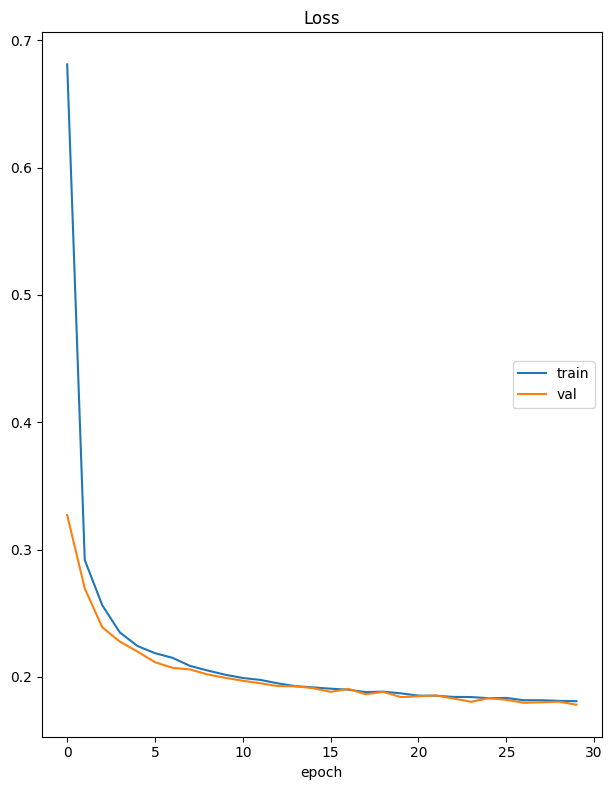

Loss
	train            	 (min:    0.181, max:    0.681, cur:    0.181)
	val              	 (min:    0.178, max:    0.327, cur:    0.178)


In [ ]:
conv1layer.to(device)

train(
    model=conv1layer,
    loader=single_loader,
    optimizer=optim,
    scheduler=scheduler,
    epochs=30,
    device=device,
    val_loader=single_val_loader,
)

In [27]:
torch.save(conv1layer.state_dict(), "conv1layer_128.pth")

In [ ]:
conv1layer.eval()

single_loader = DataLoader(train_single_file_ds, batch_size=1024)
temp = torch.tensor([0.8], device=device, dtype=torch.float32)
x = torch.tensor([lat_size // 2 - 1], device=device, dtype=torch.float32)
y = torch.tensor([lat_size // 2 - 1], device=device, dtype=torch.float32)

initial = []
deformed = []

shift_field = conv1layer(temp, x, y)

with torch.no_grad():
    for batch, inputs in enumerate(single_loader):
        inputs = tuple(input.to(device) for input in inputs)
        lats = inputs[0]
        # print(shift_field.size())
        deformed.append(deformed_corr_2d(lats, temp, shift_field, x, y))
        initial.append(corr_2d(lats, x, y))

initial = torch.cat(initial, dim=0).cpu()
deformed = torch.cat(deformed, dim=0).cpu()

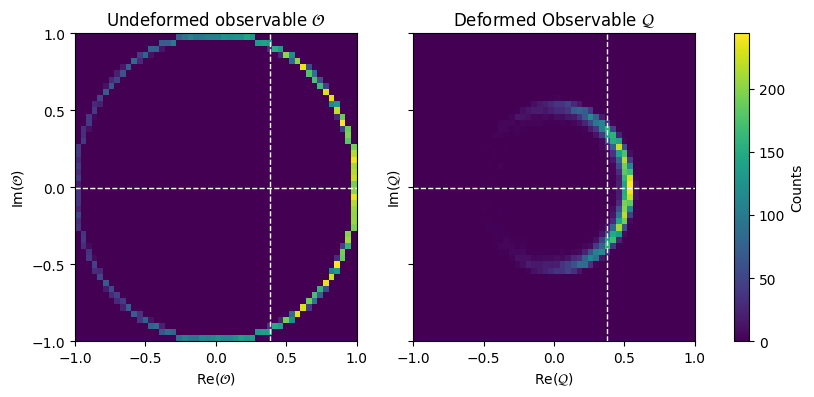

In [21]:
plot_hists(initial, deformed)

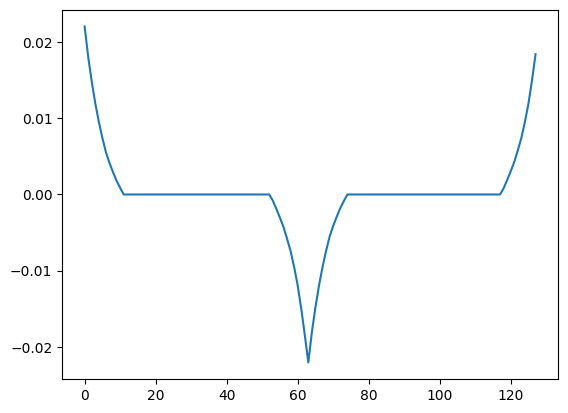

In [16]:
plt.plot(
    conv1layer.cpu()(
        torch.tensor([0.8], dtype=torch.float32),
        torch.tensor([63], dtype=torch.float32),
        torch.tensor([63], dtype=torch.float32),
    )
    .mean(dim=1)
    .squeeze()
    .detach()
    .numpy()
)

**U-Net architecture for temperation and separation generalization**

Separation allowed to vary over the full lattice, and a set temperatures is used for training

Consider boltzmann reweighting to interpolate between temperatures?

Loss function:
$$\frac{1}{L^2}\sum_{\mathbf{x}\in\Lambda}\int_{t_0}^{t_1}dt\,\rho(t) \cdot \mathcal{L}\left[\Delta(\mathbf{x},t);\,\mathbf{x},t \right]$$

$$\mathcal{L}\left[\Delta(\mathbf{x},t);\,\mathbf{x},t \right] = \left[\mathrm{Re}\left\langle \mathcal{Q(\mathbf{x},t)} \right\rangle\right]^2 + \lambda\sum_{\langle \mathbf{a}\,\mathbf{b} \rangle}\left|\Delta(\mathbf{a},t)-\Delta(\mathbf{b},t)\right|^2$$

$$\mathcal{Q}(\mathbf{x},t)=\exp\left[i(\tilde{\theta}(\mathbf{x},t) - \tilde{\theta}(\mathbf{0},t))\right]\cdot\exp\left[{-\beta(H(\tilde{\Omega})-H(\Omega))}\right]$$

$$\Omega=\left\{\theta(\mathbf{x}) | \mathbf{x}\in \Lambda\right\},\, \tilde{\theta}(\mathbf{x}) = \theta(\mathbf{x},t) + i\Delta(\mathbf{x,t})$$

With $\rho(t)$ some probability density that has support over $[t_0,t_1]$. Currently using a uniform sampling in $\beta$ rather than $t$, which amounts to the change of variables $d\beta=-dT/T^2$

The addition $\lambda$ regularization term penalizes heavy gradients in the shift field to promote stability. This is not motivated physically as much as it is from a machine learning point of view

In [5]:
unet = UNet(lat_size=128, min_size=4)
unet.load_state_dict(torch.load("unet_state_dict_128.pth"))
unet.to(device)

UNet(
  (encoder_expand_convs): ModuleList(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (1): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
  )
  (encoder_refine_convs): ModuleList(
    (0): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (1): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
training_sample_weights = reweight(
    torch.stack([train_multi_file_ds[i][1] for i in range(len(train_multi_file_ds))]).detach().numpy(),
    dist=lambda x: x**-2,
)

np.save("L_128/U-Net/train_sample_weights.npy", training_sample_weights)

In [10]:
training_sample_weights = np.load("L_128/U-Net/train_sample_weights.npy")

training_sample_weights

array([83.67347 , 83.67347 , 83.67347 , ..., 33.884296, 33.884296,
       33.884296], shape=(738000,), dtype=float32)

In [11]:
sampler = WeightedRandomSampler(training_sample_weights, num_samples=len(train_multi_file_ds), replacement=True)

In [12]:
multi_train_loader = DataLoader(train_multi_file_ds, batch_size=64, pin_memory=True, sampler=sampler)
multi_val_loader = DataLoader(val_multi_file_ds, batch_size=256, shuffle=False, pin_memory=True)

optim = Adam(unet.parameters(), lr=1e-3)
scheduler = CosineAnnealingWarmRestarts(optim, 2500, eta_min=1e-5)

In [ ]:
train(
    model=unet,
    loader=multi_train_loader,
    optimizer=optim,
    scheduler=scheduler,
    epochs=20,
    device=device,
    val_loader=multi_val_loader,
)

In [24]:
torch.save(unet.state_dict(), "unet_state_dict_128.pth")

In [ ]:
unet.eval()

x = torch.tensor([lat_size // 2 - 1], device=device, dtype=torch.float32)
y = torch.tensor([lat_size // 2 - 1], device=device, dtype=torch.float32)

tempwise_shift_fields = []

initial_corrs = []
deformed_corrs = []

for ds in train_multi_file_ds.datasets[::3]:  # Using every 4th dataset for efficiency

    print(f"Processing temperature: {ds.T}")

    with torch.no_grad():

        temp = torch.tensor([ds.T], device=device, dtype=torch.float32)
        loader = DataLoader(ds, batch_size=4096)

        initial = []
        deformed = []

        shift_fields = unet(temp, x, y)

        tempwise_shift_fields.append(shift_fields.cpu())

        for batch, inputs in enumerate(loader):

            inputs = tuple(input.to(device) for input in inputs)
            lats = inputs[0]

            deformed.append(deformed_corr_2d(lats, temp, shift_fields, x, y))
            initial.append(corr_2d(lats, x, y))

        initial = torch.cat(initial, dim=0).cpu()
        deformed = torch.cat(deformed, dim=0).cpu()

        initial_corrs.append(initial)
        deformed_corrs.append(deformed)

tempwise_shift_fields = torch.cat(tempwise_shift_fields, dim=0)

initial_corrs = torch.stack(initial_corrs, dim=0)
deformed_corrs = torch.stack(deformed_corrs, dim=0)

Processing temperature: 0.7
Processing temperature: 0.73
Processing temperature: 0.76
Processing temperature: 0.79
Processing temperature: 0.82
Processing temperature: 0.85
Processing temperature: 0.88
Processing temperature: 0.91
Processing temperature: 0.94
Processing temperature: 0.97
Processing temperature: 1.0
Processing temperature: 1.03
Processing temperature: 1.06
Processing temperature: 1.09


In [ ]:
tempwise_shift_fields = tempwise_shift_fields - tempwise_shift_fields.mean(dim=(1, 2), keepdim=True)

In [ ]:
unet.eval()

init_corrs = []
def_corrs = []

for i in range(lat_size // 4, lat_size * 3 // 4 + 1, 2):  # Using every 2nd separation for efficiency
    print(f"Sep: x=y={i}")

    x = torch.tensor([i], device=device, dtype=torch.float32)
    y = torch.tensor([i], device=device, dtype=torch.float32)

    init_t_corrs = []
    def_t_corrs = []

    for ds in train_multi_file_ds.datasets[::2]:  # Using every 2nd temp for efficiency
        print(f"\tTemp: {ds.T}")

        with torch.no_grad():
            temp = torch.tensor([ds.T], device=device, dtype=torch.float32)
            shift_fields = unet(temp, x, y)

            loader = DataLoader(ds, batch_size=4096)
            init_batches = []
            def_batches = []

            for inputs in loader:
                inputs = tuple(inp.to(device) for inp in inputs)
                lats = inputs[0]

                init_batches.append(corr_2d(lats, x, y).cpu())
                def_batches.append(deformed_corr_2d(lats, temp, shift_fields, x, y).cpu())

            init_t_corrs.append(torch.cat(init_batches, dim=0))
            def_t_corrs.append(torch.cat(def_batches, dim=0))

    init_corrs.append(torch.stack(init_t_corrs, dim=0))
    def_corrs.append(torch.stack(def_t_corrs, dim=0))

init_corrs = torch.stack(init_corrs, dim=0)
def_corrs = torch.stack(def_corrs, dim=0)

In [26]:
torch.save(tempwise_shift_fields, "tempwise_shift_fields_128.pth")
torch.save((init_corrs, def_corrs), "corrs_128.pth")

In [8]:
init_corrs, def_corrs = torch.load("corrs_128.pth")

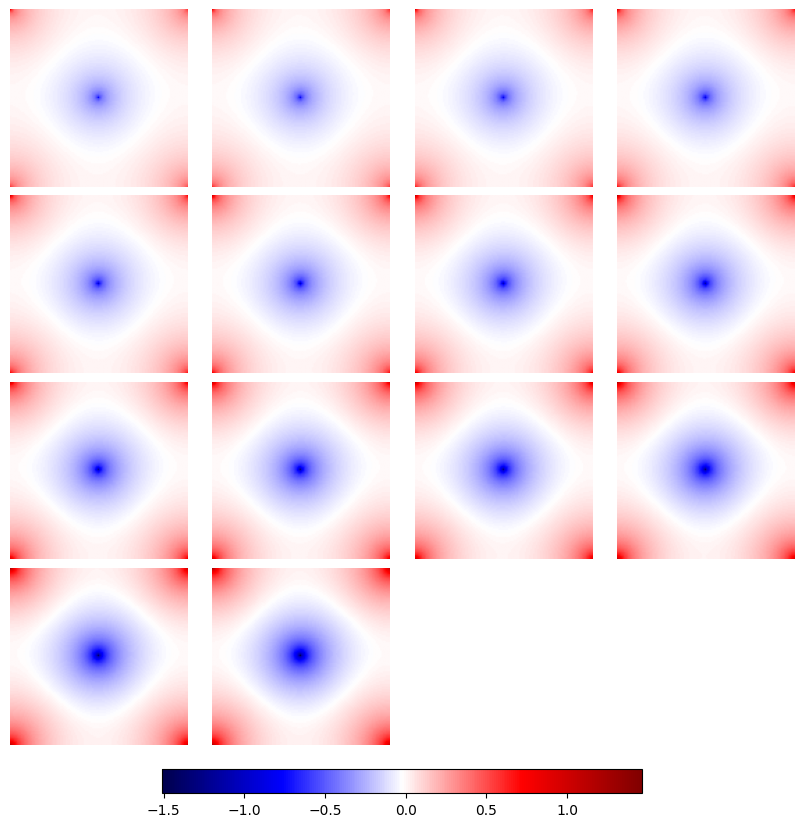

In [9]:
plot_tensor_grid(tempwise_shift_fields)